In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Predict penguin weights (Multiple linear regression)


<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/ai-ml-recipes/blob/main/notebooks/regression/linear_regression/penguim_weight_prediction.ipynb">
      <img src="https://avatars.githubusercontent.com/u/33467679?s=200&v=4" width="32px" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/ai-ml-recipes/blob/main/notebooks/regression/linear_regression/penguim_weight_prediction.ipynb">
      <img src="https://github.githubassets.com/assets/GitHub-Mark-ea2971cee799.png" width="32px" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/ai-ml-recipes/main/notebooks/regression/linear_regression/penguim_weight_prediction.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/bigquery/import?url=https://github.com/GoogleCloudPlatform/ai-ml-recipes/blob/main/notebooks/regression/linear_regression/penguim_weight_prediction.ipynb">
      <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTW1gvOovVlbZAIZylUtf5Iu8-693qS1w5NJw&s" alt="BQ logo" width="35">
      Open in BQ Studio
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fai-ml-recipes%2Fmain%2Fnotebooks%2Fregression%2Flinear_regression%2Fpenguim_weight_prediction.ipynb">
    <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
    Open in Colab Enterprise
    </a>
  </td>

</table>

## Overview

This notebook shows how to predict penguim weights fitting a multiple linear regression model using BigQuery Dataframes.

#### **Steps**
Using Bigframes (BigQuery Dataframes),
1) It reads the [```penguins```](https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=ml_datasets&t=penguins) table from BigQuery Public Datasets.  
2) It fits a multiple linear regression model that predicts the weight of penguins based on the following features:  
        **Features**: 'island', 'culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'sex'  
        **Target**: 'body_mass_g'  
3) It evaluates and plot the results.  

References:
- [BQML linear regression example](https://github.com/googleapis/python-bigquery-dataframes/blob/main/notebooks/ml/bq_dataframes_ml_linear_regression.ipynb)
- [BQML linear regression tutorial](https://cloud.google.com/bigquery-ml/docs/linear-regression-tutorial)
- [BigQuery DataFrames](https://cloud.google.com/python/docs/reference/bigframes/latest)

### Costs

This tutorial uses billable components of Google Cloud:

* BigQuery (compute)
* BigQuery ML

Learn about [BigQuery compute pricing](https://cloud.google.com/bigquery/pricing#analysis_pricing_models)
and [BigQuery ML pricing](https://cloud.google.com/bigquery/pricing#bqml),
and use the [Pricing Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Setup

In [ ]:
!pip install bigframes -q


1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 credit towards your compute/storage costs.

2. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

3. [Enable the BigQuery API](https://console.cloud.google.com/flows/enableapi?apiid=bigquery.googleapis.com).

4. If you are running this notebook locally, install the [Cloud SDK](https://cloud.google.com/sdk).

### Import dependencies

In [69]:
from google.cloud import bigquery

import bigframes.pandas as bpd
from bigframes.ml.linear_model import LinearRegression as BQLinearRegression

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression as SKLinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

import pandas as pd
import matplotlib.pyplot as plt
sns.set_theme(color_codes=True)

### Set BigQuery DataFrames options

In [70]:
PROJECT_ID = "<YOUR_GCP_PROJECT>"
REGION = "US"

In [71]:
# Note: The project option is not required in all environments.
# On BigQuery Studio, the project ID is automatically detected.
bpd.options.bigquery.project = PROJECT_ID
# Note: The location option is not required.
# It defaults to the location of the first table or query
# passed to read_gbq(). For APIs where a location can't be
# auto-detected, the location defaults to the "US" location.
bpd.options.bigquery.location = REGION

If you want to reset the location of the created DataFrame or Series objects, reset the session by executing `bpd.close_session()`. After that, you can reuse `bpd.options.bigquery.location` to specify another location.

## Read a BigQuery table into a BigQuery DataFrames DataFrame

Read the [```penguins``` table](https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=ml_datasets&t=penguins) into a BigQuery DataFrames DataFrame:

In [72]:
df = bpd.read_gbq("bigquery-public-data.ml_datasets.penguins")

In [73]:
df.head(10)

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Gentoo penguin (Pygoscelis papua),Biscoe,50.5,15.9,225.0,5400.0,MALE
1,Gentoo penguin (Pygoscelis papua),Biscoe,45.1,14.5,215.0,5000.0,FEMALE
2,Adelie Penguin (Pygoscelis adeliae),Torgersen,41.4,18.5,202.0,3875.0,MALE
3,Adelie Penguin (Pygoscelis adeliae),Torgersen,38.6,17.0,188.0,2900.0,FEMALE
4,Gentoo penguin (Pygoscelis papua),Biscoe,46.5,14.8,217.0,5200.0,FEMALE
5,Adelie Penguin (Pygoscelis adeliae),Biscoe,35.0,17.9,192.0,3725.0,FEMALE
6,Adelie Penguin (Pygoscelis adeliae),Dream,37.5,18.9,179.0,2975.0,<NA>
7,Gentoo penguin (Pygoscelis papua),Biscoe,42.0,13.5,210.0,4150.0,FEMALE
8,Gentoo penguin (Pygoscelis papua),Biscoe,48.5,14.1,220.0,5300.0,MALE
9,Adelie Penguin (Pygoscelis adeliae),Torgersen,45.8,18.9,197.0,4150.0,MALE


In [74]:
df.dtypes

species              string[pyarrow]
island               string[pyarrow]
culmen_length_mm             Float64
culmen_depth_mm              Float64
flipper_length_mm            Float64
body_mass_g                  Float64
sex                  string[pyarrow]
dtype: object

## Clean and prepare dataset

Drop rows with `NULL` values in order to create a BigQuery DataFrames DataFrame for the training data:

In [78]:
# Drop rows with nulls
dataset = df.dropna()

In [ ]:
training_data = dataset.sample(frac=0.9,random_state=200)
test_data = dataset.drop(training_data.index)

In [80]:
print("Training data sample size: ", training_data.size)
print("Test data sample size: ", test_data.size)

Training data sample size:  2107


Test data sample size:  231


Select features and labels

In [81]:
features_columns = ['island', 'culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'sex']
label_colum = ['body_mass_g']

In [82]:
features_training = training_data[features_columns]
labels_training = training_data[label_colum]

In [83]:
features_test = test_data[features_columns]
labels_test = test_data[label_colum]

#### Visualize the dataset

In [84]:
sample_to_plot = training_data.to_pandas().sample(n=200, random_state=100)

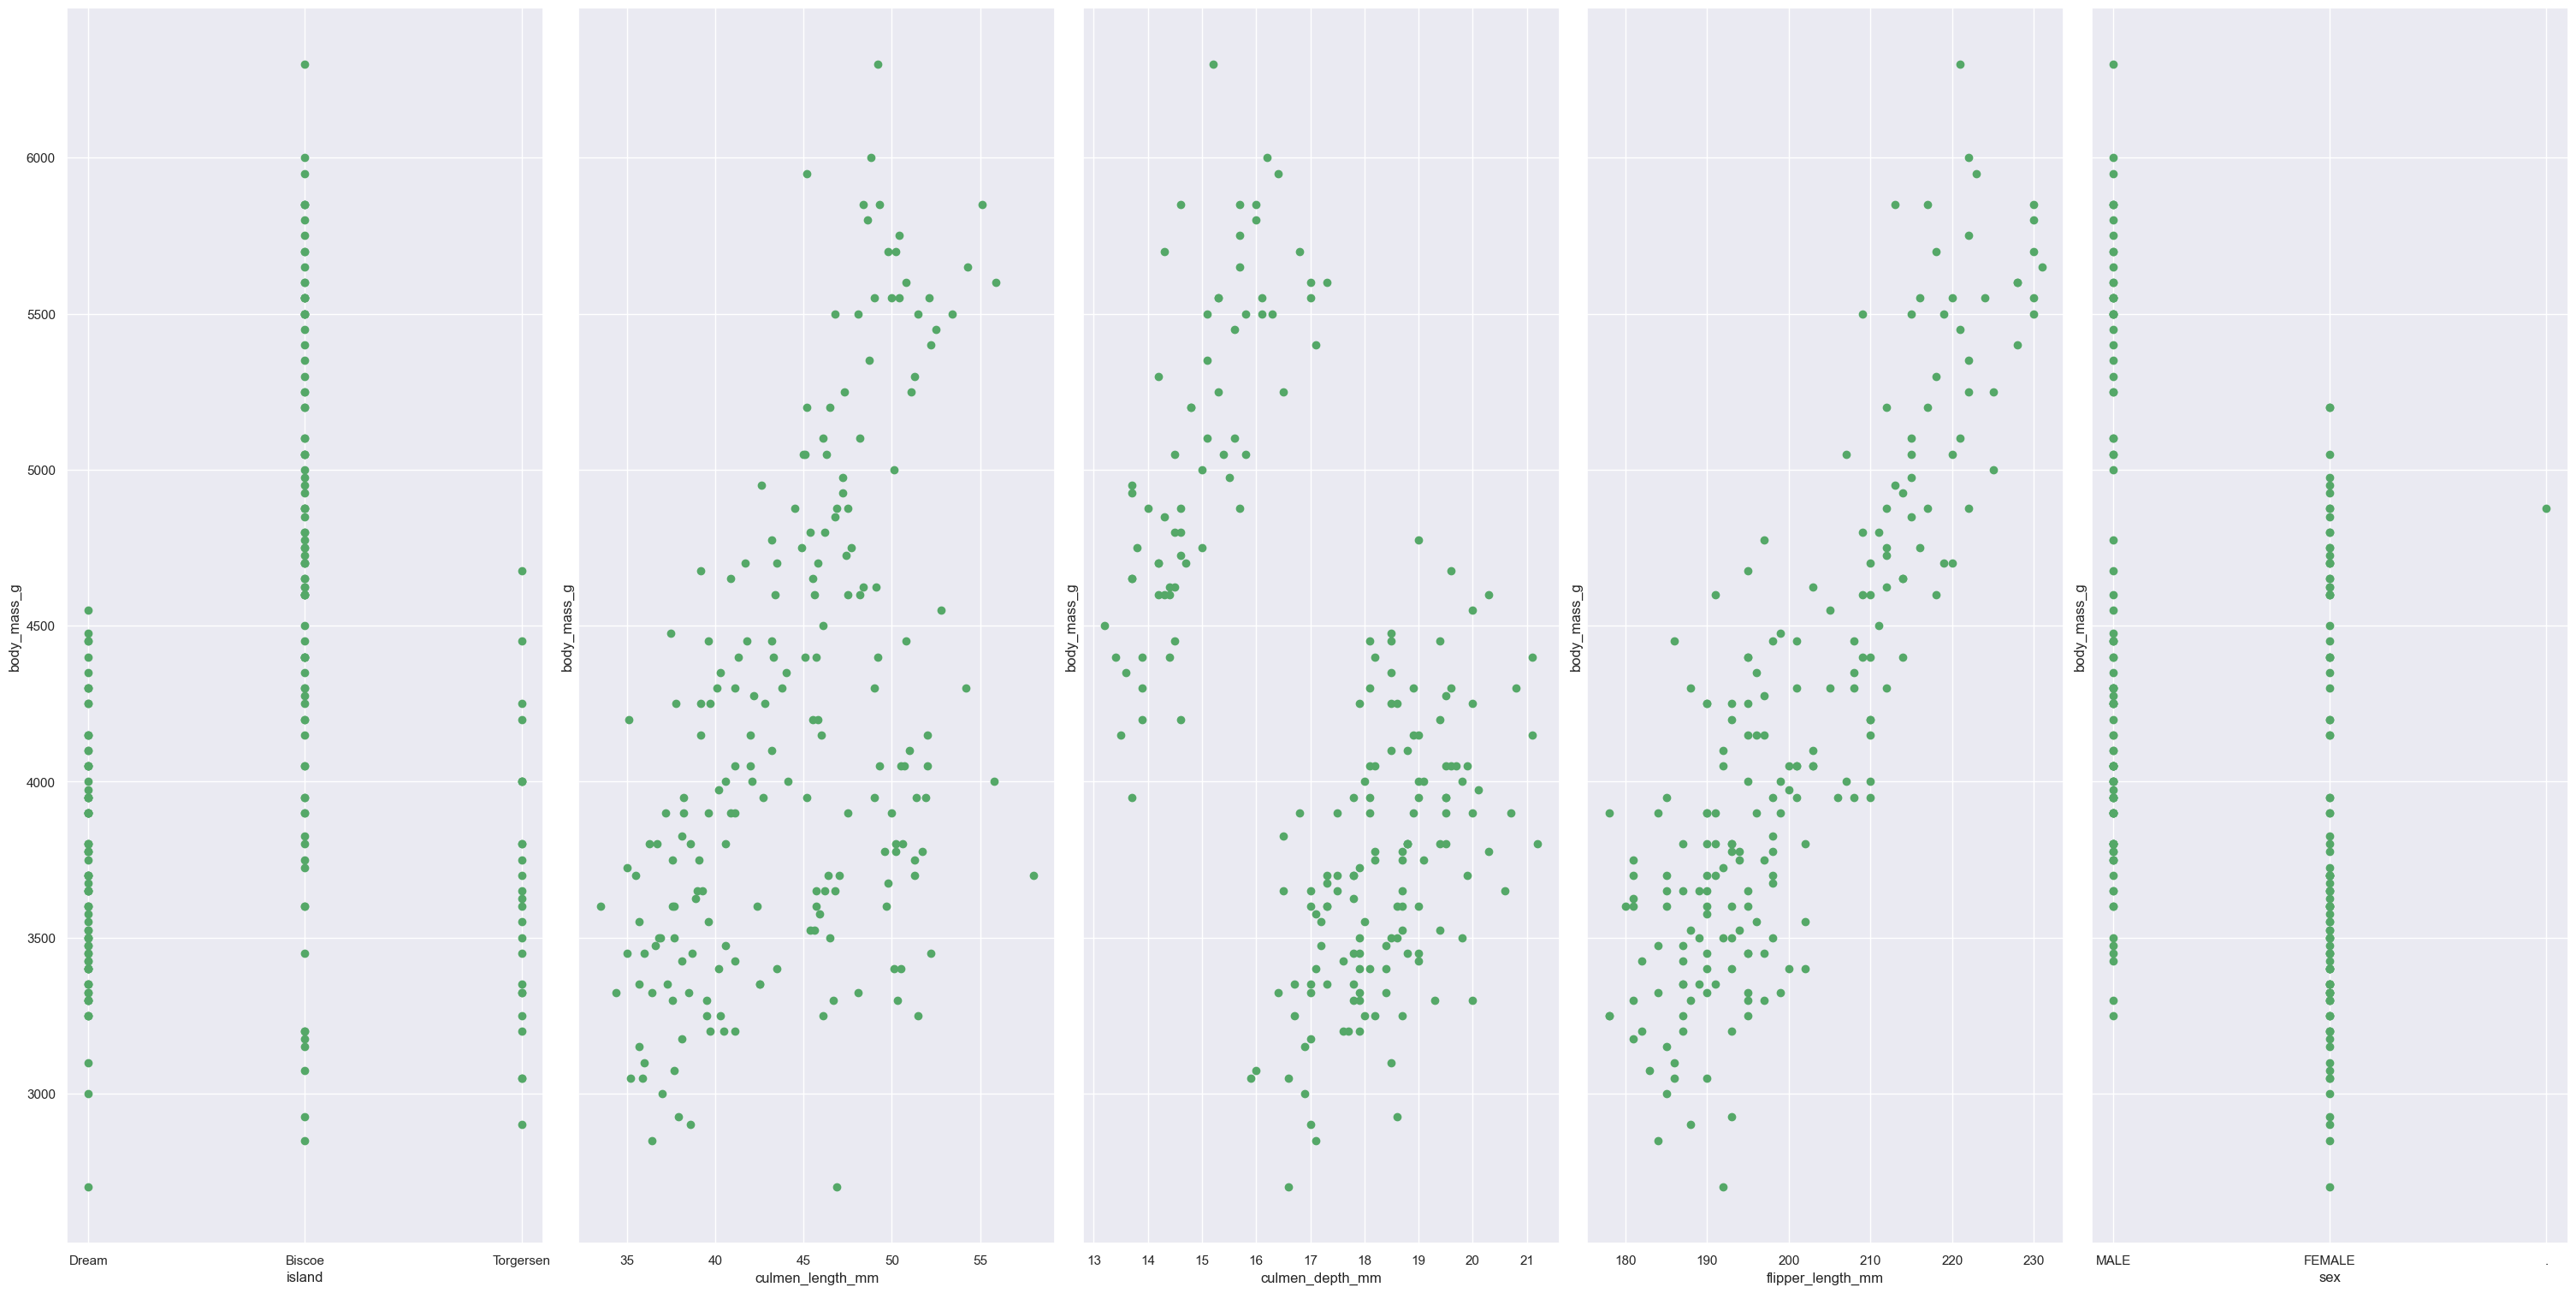

In [85]:
fig, axes = plt.subplots(1, len(features_columns), sharey=True, constrained_layout=True, figsize=(30,15))

for i, e in enumerate(features_columns):
  axes[i].set_xlabel(str(e))
  axes[i].set_ylabel('body_mass_g')
  axes[i].scatter(sample_to_plot[e], sample_to_plot["body_mass_g"], color='g')

## Multiple Linear Regression using BigQuery Dataframes

BigQuery DataFrames ML lets you move from exploring data to creating machine learning models through its scikit-learn-like API, `bigframes.ml`. BigQuery DataFrames ML supports several types of [ML models](https://cloud.google.com/python/docs/reference/bigframes/latest#ml-capabilities).

In this notebook, you create a linear regression model, a type of regression model that generates a continuous value from a linear combination of input features.

When you create a model with BigQuery DataFrames ML, it is saved locally and limited to the BigQuery session. However, as you'll see in the next section, you can use `to_gbq` to save the model permanently to your BigQuery project.

### Train the model using `bigframes.ml`

When you pass the feature columns without transforms, BigQuery ML uses [automatic preprocessing](https://cloud.google.com/bigquery/docs/auto-preprocessing) to encode string values and scale numeric values.  
BigQuery ML also [automatically splits the data for training and evaluation](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create-glm#data_split_method).  
Since there are between 500 and 50_000 rows in our training dataset, 20% of the data is used as evaluation data.

In [ ]:
bq_model = BQLinearRegression(fit_intercept=True, enable_global_explain=True)
bq_model.fit(features_training, labels_training)

In [87]:
bq_model.get_params()

{'calculate_p_values': False,
 'early_stop': True,
 'enable_global_explain': True,
 'fit_intercept': True,
 'l2_reg': 0.0,
 'learn_rate_strategy': 'line_search',
 'ls_init_learn_rate': 0.1,
 'max_iterations': 20,
 'min_rel_progress': 0.01,
 'optimize_strategy': 'normal_equation'}

### Score the model

Check how the model performed by using the `score` method. More information on model scoring can be found [here](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-evaluate#mlevaluate_output).

In [88]:
bq_model.score(features_training, labels_training)

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,262.79297,105406.044309,0.006682,219.307948,0.833374,0.833374


### Predict using the trained model

Use the model to predict the body mass of the data row you saved earlier to the `test_data` DataFrame:

In [89]:
bq_predictions = bq_model.predict(test_data)
bq_predictions.head()

,predicted_body_mass_g,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
30,3483.093747,Chinstrap penguin (Pygoscelis antarctica),Dream,46.6,17.8,193.0,3800.0,FEMALE
38,3921.654298,Adelie Penguin (Pygoscelis adeliae),Biscoe,40.6,18.6,183.0,3550.0,MALE
41,2972.345633,Adelie Penguin (Pygoscelis adeliae),Torgersen,40.2,17.0,176.0,3450.0,FEMALE
55,3488.070871,Adelie Penguin (Pygoscelis adeliae),Torgersen,40.9,16.8,191.0,3700.0,FEMALE
67,5235.107126,Gentoo penguin (Pygoscelis papua),Biscoe,47.6,14.5,215.0,5400.0,MALE


As you can, we get an additional column, predicted_body_mass_g, which can be compared to the labal body_mass_g.  

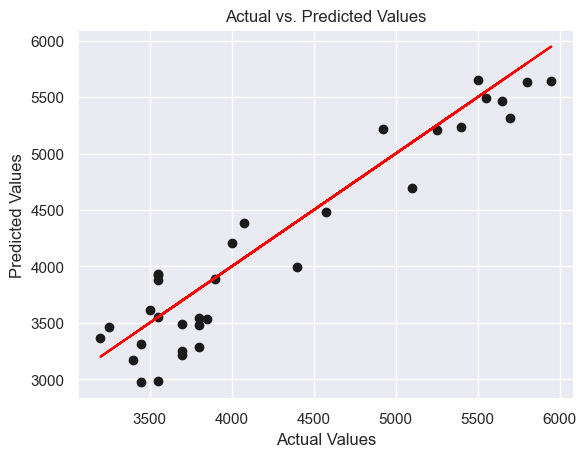

In [90]:
plt.scatter(bq_predictions["body_mass_g"], bq_predictions["predicted_body_mass_g"], color='k')
plt.plot(bq_predictions["body_mass_g"], bq_predictions["body_mass_g"], color='red')  # Line of perfect fit
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()

### Save the results in BigQuery

The model is saved locally within this session. You can save the model permanently to BigQuery for use in future sessions, and to make the model sharable with others.

Create a BigQuery dataset, adding a name for your dataset as the `DATASET_ID` variable:

In [91]:
DATASET_ID = "penguim"  # @param {type:"string"}

client = bigquery.Client(project=PROJECT_ID)
dataset = bigquery.Dataset(PROJECT_ID + "." + DATASET_ID)
dataset.location = REGION
dataset = client.create_dataset(dataset, exists_ok=True)
print(f"Dataset {dataset.dataset_id} created.")

Dataset penguim created.


#### Save the predictions table

In [ ]:
bq_predictions.to_gbq(DATASET_ID + ".penguin_weight_predictions" , if_exists="replace")

#### Save the model itself

In [ ]:
bq_model.to_gbq(DATASET_ID + ".penguin_weight_model", replace=True)

## Multiple Linear Regression using scikit-learn

In this section we use scikit-learn to compare the results with BigQuery ML.  
As you will see, you need to perform more feature transformations with scikit-learn, which are automatically performed by BigQuery ML.  
Additionally, the dataframes are put in to memory and the training perform on the environment you are in, instead of leveraging BigQuery's compute and storage, which could handle larger datasets and models.  

Bigframes dataframes are converted back to pandas dataframes.  

In [ ]:
features_training_pandas = features_training.to_pandas()
labels_training_pandas = labels_training.to_pandas()

### Encoding categorial features

Unlike in BigQuery ML, where feature columns are [automatic preprocessed](https://cloud.google.com/bigquery/docs/auto-preprocessing), we need to encode our categorical features for sklearn model.  

In [97]:
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(features_training_pandas[['sex','island']])
encoded_df = pd.DataFrame(encoded_features.toarray(),
                          columns=encoder.get_feature_names_out(['sex','island']),
                          index=features_training_pandas.index)  # Use the original index

# Concatenate encoded features with numerical features
features_training_encoded_pandas = pd.concat([features_training_pandas.drop(['sex','island'], axis=1), encoded_df], axis=1)

More feature processing could also be performed such as numberical feature standartization, etc  

In [98]:
features_training_encoded_pandas

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,sex_.,sex_FEMALE,sex_MALE,island_Biscoe,island_Dream,island_Torgersen
146,46.6,14.2,210.0,0.0,1.0,0.0,1.0,0.0,0.0
150,36.7,18.8,187.0,0.0,1.0,0.0,0.0,0.0,1.0
66,40.7,17.0,190.0,0.0,0.0,1.0,0.0,1.0,0.0
233,35.7,17.0,189.0,0.0,1.0,0.0,0.0,0.0,1.0
44,42.5,20.7,197.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
186,48.1,16.4,199.0,0.0,1.0,0.0,0.0,1.0,0.0
77,49.6,16.0,225.0,0.0,0.0,1.0,1.0,0.0,0.0
123,43.4,14.4,218.0,0.0,1.0,0.0,1.0,0.0,0.0
271,59.6,17.0,230.0,0.0,0.0,1.0,1.0,0.0,0.0


#### Train the model using `scikit-learn`

In [99]:
sk_model = SKLinearRegression()
sk_model.fit(features_training_encoded_pandas, labels_training_pandas)

LinearRegression()

In [100]:
sk_model.coef_

array([[   5.92130074,  -49.17396307,   33.44970232,  -60.53698475,
        -228.56777289,  289.10475764,  201.35001892, -128.90199892,
         -72.44802   ]])

In [101]:
sk_model.intercept_

array([-2015.86510063])

#### Predict using the trained model

In [ ]:
features_test_pandas = features_test.to_pandas()
labels_test_pandas = labels_test.to_pandas()

The same feature processing is required for prediction.  

In [103]:
encoded_features = encoder.transform(features_test_pandas[['sex','island']])
encoded_df = pd.DataFrame(encoded_features.toarray(),
                          columns=encoder.get_feature_names_out(['sex','island']),
                          index=features_test_pandas.index)  # Use the original index
features_test_encoded = pd.concat([features_test_pandas.drop(['sex','island'], axis=1), encoded_df], axis=1)

In [104]:
sk_predictions = sk_model.predict(features_test_encoded)

In [105]:
sk_predictions

array([[3483.09374744],
       [3921.6542977 ],
       [2972.34563262],
       [3488.07087057],
       [5235.10712572],
       [4482.4120673 ],
       [3531.32747129],
       [3547.34548978],
       [2987.77211986],
       [3935.02264044],
       [3283.02816009],
       [3879.8981787 ],
       [5215.28901739],
       [4203.74348862],
       [3175.30951369],
       [5496.47379505],
       [3991.1390815 ],
       [5647.58627156],
       [3886.50979698],
       [5631.05769241],
       [4693.55643423],
       [5315.24558032],
       [3548.94815233],
       [5468.72657712],
       [5654.24822548],
       [3212.73710039],
       [3616.26859404],
       [3364.19768604],
       [3315.06145633],
       [3254.05151982],
       [4383.68734835],
       [5212.27067606],
       [3466.91327744]])

In [106]:
mae, mse = mean_absolute_error(labels_test_pandas, sk_predictions), mean_squared_error(labels_test_pandas, sk_predictions)

print("Mean Absolute Error", mae)
print("Mean Squared Error", mse)

Mean Absolute Error 263.84080065881744
Mean Squared Error 91767.10714231782


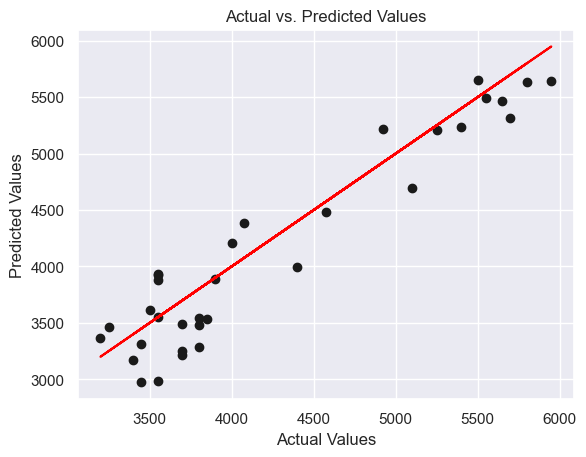

In [107]:
plt.scatter(labels_test_pandas, sk_predictions, color='k')
plt.plot(labels_test_pandas, labels_test_pandas, color='red')  # Line of perfect fit
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()

As you can see, the results are similar to the BigQuery results.  